In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

2024-03-27 18:32:36.775250: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/opt/rhel-7.x86_64/gnu/hdf5/1.12.0/lib:/opt/rhel-7.x86_64/gnu4.9/openmpi/1.10.2/lib:/opt/rhel-7.x86_64/gnu/gsl/2.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2024-03-27 18:32:36.775293: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams['figure.dpi'] = 100

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 0
nmesh = 1024
cosmology = fiducial.AbacusSummitBase()
z = 0.8

# Mocks
nmocks = 10

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## Average density

In [4]:
abacus_halos = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}.npy'.format(z))
nbar = abacus_halos.size/(boxsize**3)

## Gaussian model

In [5]:
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1, nbar=nbar, damping=False)

/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:359: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


## Bias

[000088.45]  03-27 18:34  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/correlation_functions/AbacusSummit_2Gpc_z0.800_2PCF.npy.


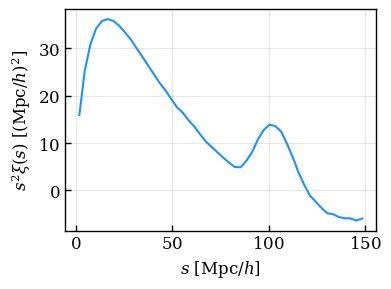

In [6]:
from pycorr import TwoPointCorrelationFunction

ells = [0]

# Abacus 2PCF
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
xi_abacus_halos = TwoPointCorrelationFunction.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_2PCF.npy'.format(z))
sep, xi_ells_abacus_halos = xi_abacus_halos.get_corr(ells=ells, return_sep=True)

bias = 1.485

plt.rcParams["figure.figsize"] = (4, 3)

for ill, ell in enumerate(ells):
    plt.plot(sep, sep**2 * xi_ells_abacus_halos[ill],  label=r'Abacus halos', color='C0', alpha=1.)
    #plt.plot(model.sep, model.sep**2 * bias**2 * model.xi, label=r'Model', ls=':', color='C1')

plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
#plt.legend()
plt.show()

## Shot noise

In [7]:
# shot noise correction for xi_R
wfield = model.smoothing_kernel_3D.c2r() / model.boxsize**3
sep, mu, w = project_to_basis(wfield, edges=(model.s, np.array([-1., 1.])), exclude_zero=False)[0][:3]
shotnoise = np.real(w / nbar)

# shot noise correction for sigma_RR
fourier_kernel = model.smoothing_kernel_3D
norm_fourier_kernel = fourier_kernel / model.boxsize**3
real_space_kernel = norm_fourier_kernel.c2r()
real_space_kernel.value = np.real(real_space_kernel.value)
w2 = integrate_pmesh_field(real_space_kernel**2)
shotnoise_sigma = w2 / nbar

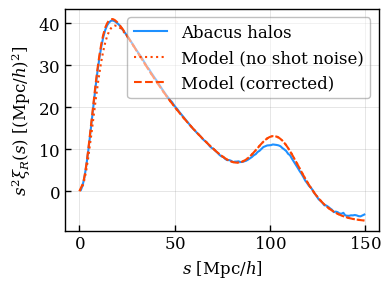

In [8]:
# Abacus smoothed 2PCF
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
xiR_abacus_halos = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_cellsize{:d}_resampler{}_xi_R.npy'.format(cellsize, resampler), allow_pickle=True)
sep, xiR_ells_abacus_halos = xiR_abacus_halos.item().get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    plt.plot(sep, sep**2 * xiR_ells_abacus_halos[ill], label=r'Abacus halos', color='C0')
    plt.plot(model.sep, model.sep**2 * bias**2 * (model.xi_R), ls=':', color='C1', label='Model (no shot noise)')
    plt.plot(model.sep, model.sep**2 * bias**2 * (model.xi_R + shotnoise), ls='--', color='C1', label='Model (corrected)')
    
plt.ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

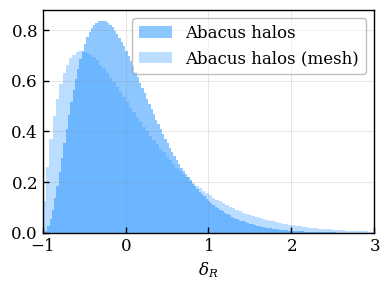

In [11]:
abacus_halos_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_halos_delta_R_mesh = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_cellsize{:d}_resampler{}_delta_R_mesh.npy'.format(z, cellsize, resampler)).ravel()

pdf_halos = plt.hist(abacus_halos_delta_R, bins=200, density=True, alpha=0.5, color='C0', label=r'Abacus halos')
pdf_halos_mesh = plt.hist(abacus_halos_delta_R_mesh, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus halos (mesh)')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
plt.legend()
plt.show()

In [12]:
def friedrich_lognormal_model(delta, sigma, delta0):
    pdf_model = np.zeros_like(delta)
    pdf_model[delta > -delta0] = scipy.stats.lognorm.pdf(delta[delta > -delta0], sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

delta = np.linspace(-1, 4, 200)

In [13]:
def compute_delta0_sigma_from_moments(delta_R, m2=None, m3=None):
    if m2 is None:
        m2 = np.mean(delta_R**2) #moment(delta_R, 2)
    if m3 is None:
        m3 = np.mean(delta_R**3) #moment(delta_R, 3)
    def tomin(delta0):
        return (m3 - 3/delta0 * m2**2 - 1/delta0**3 * m2**3)**2
    res = minimize(tomin, x0=1.)
    print(res)
    delta0 = res.x[0]
    sigma = np.sqrt(np.log(1 + m2/res.x[0]**2))
    return delta0, sigma

delta0, sigma = compute_delta0_sigma_from_moments(abacus_halos_delta_R)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.232403823533887e-09
        x: [ 1.717e+00]
      nit: 8
      jac: [-6.072e-06]
 hess_inv: [[ 6.186e+01]]
     nfev: 18
     njev: 9


In [14]:
def to_minimize(params, *args):
    pdf = args
    delta0 = params[0]
    sigma = params[1]
    x = pdf[0]
    y = friedrich_lognormal_model((pdf[1][1:]+pdf[1][:-1])/2., sigma, delta0)
    return np.sum((x-y)**2)

def compute_bestfit_delta0_sigma(delta_R_pdf):
    res = minimize(to_minimize, x0=np.array([1., model.sigma_RR[0]]), args=delta_R_pdf)
    print(res)
    delta0 = res.x[0]
    sigma = res.x[1]
    return delta0, sigma
    
delta0_3, sigma_3 = compute_bestfit_delta0_sigma(pdf_halos)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.025215448610450702
        x: [ 1.429e+00  3.770e-01]
      nit: 14
      jac: [-5.821e-09 -9.337e-08]
 hess_inv: [[ 5.509e-01 -1.546e-01]
            [-1.546e-01  4.684e-02]]
     nfev: 54
     njev: 18


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.06062063179652229
        x: [ 1.511e+00]
      nit: 4
      jac: [ 3.143e-06]
 hess_inv: [[ 6.067e-01]]
     nfev: 10
     njev: 5


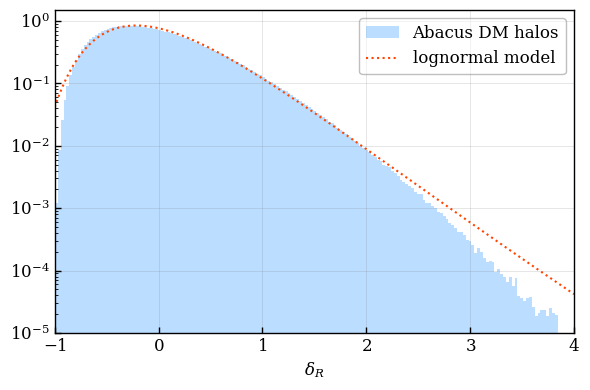

In [20]:
def to_minimize(delta0, *args):
    shotnoise = args[2]
    sigma = np.sqrt(np.log(1 + bias**2 * (model.sigma_RR**2 + shotnoise)/delta0**2))
    x = args[0]
    y = friedrich_lognormal_model((args[1][1:]+args[1][:-1])/2., sigma, delta0)
    return np.sum((x-y)**2)

def compute_bestfit_delta0(delta_R_pdf, return_sigma=True, shotnoise=0):
    res = minimize(to_minimize, x0=bias, args=(delta_R_pdf[0], delta_R_pdf[1], shotnoise))
    print(res)
    delta0 = res.x[0]
    sigma = np.sqrt(np.log(1 + bias**2 * (model.sigma_RR**2 + shotnoise)/delta0**2))
    return delta0, sigma
    
delta0_2, sigma_2 = compute_bestfit_delta0(pdf_halos, shotnoise=shotnoise_sigma)

plt.rcParams["figure.figsize"] = (6, 4)

plt.hist(abacus_halos_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus DM halos')
plt.plot(delta, friedrich_lognormal_model(delta, sigma, delta0), color='C1', ls=':', label=r'lognormal model')
#plt.plot(delta, friedrich_lognormal_model(delta, sigma_2, delta0_2), color='C1', ls='--', label=r'best fit $\delta_0$ (theory $\sigma_{Y, RR}$)')
#plt.plot(delta, friedrich_lognormal_model(delta, sigma_3, delta0_3), color='C1', ls=':', label=r'best fit $\sigma_{Y, RR}$, $\delta_0$')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
plt.yscale('log')
plt.ylim((1e-5, 1.5))
plt.legend()
plt.show()

## Model with bias

In [51]:
def bias_model(delta_m, sigma_m, b1, b2):
    res = b1 * delta_m + b2 * (delta_m**2 - sigma_m**2)
    return res

def get_unbiased_delta(delta, b1, b2, sigma):
    def tomin(deltam):
        return (delta - bias_model(deltam, sigma, b1, b2))**2
    res = minimize(tomin, x0=delta)
    return res.x[0]

def get_unbiased_delta_num(delta, b1, b2, sigma):
    if b2==0:
        return delta/b1
    else:
        res = np.zeros(len(delta))
        mask = b1**2 + 4*b2*(b2*sigma**2+delta) < 0
        res[mask] = -b1/(2*b2)
        r1 = (-b1 - np.sqrt(b1**2 + 4*b2*(b2*sigma**2+delta[~mask])))/(2*b2)
        r2 = (-b1 + np.sqrt(b1**2 + 4*b2*(b2*sigma**2+delta[~mask])))/(2*b2)
        r = np.maximum(r1, r2)
        res[~mask] = r
        return res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.017051539541685614
        x: [ 1.607e+00  4.281e-01  7.949e-01 -3.511e-02]
      nit: 16
      jac: [ 4.423e-02  1.184e-03  9.202e-02  2.517e-02]
 hess_inv: [[ 8.399e-01 -2.953e-01  3.378e-02  2.380e-01]
            [-2.953e-01  1.084e-01 -1.982e-02 -8.403e-02]
            [ 3.378e-02 -1.982e-02  2.420e-02  1.401e-02]
            [ 2.380e-01 -8.403e-02  1.401e-02  7.301e-02]]
     nfev: 403
     njev: 75


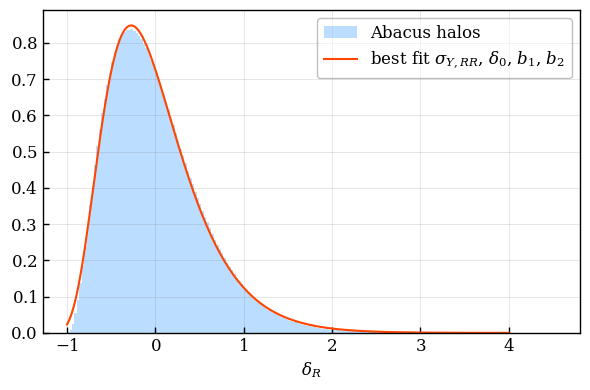

In [52]:
def biased_lognormal_model(delta, sigma, delta0, b1, b2):
    delta2 = delta0**2*(np.exp(sigma**2)-1)
    #delta_bias = b1*delta + b2/2.*(delta**2 - delta2)
    deltam1 = np.array([get_unbiased_delta(d, b1, b2, np.sqrt(delta2)) for d in delta])
    #deltam2 = get_unbiased_delta_num(delta, b1, b2, np.sqrt(delta2))
    pdf_model1 = scipy.stats.lognorm.pdf(deltam1, sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))/np.abs(b1 + 2*b2*deltam1)
    #pdf_model2 = scipy.stats.lognorm.pdf(deltam2, sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))/np.abs(b1 + 2*b2*deltam2)
    return pdf_model1#, pdf_model2

delta = np.linspace(-1, 4, 200)

def to_minimize4(params, *args):
    pdf = args
    delta0 = params[0]
    sigma = params[1]
    b1 = params[2]
    b2 = params[3]
    x = pdf[0]
    y = biased_lognormal_model((pdf[1][1:]+pdf[1][:-1])/2., sigma, delta0, b1, b2)
    return np.sum((x-y)**2)

def compute_bestfit_delta0_sigma_4(delta_R_pdf):
    res = minimize(to_minimize4, x0=np.array([1, sigma_3, 1, 0.]), args=delta_R_pdf)
    print(res)
    delta0 = res.x[0]
    sigma = res.x[1]
    b1 = res.x[2]
    b2 = res.x[3]
    return delta0, sigma, b1, b2
    
delta0_4, sigma_4, b1, b2 = compute_bestfit_delta0_sigma_4(pdf_halos)    

plt.rcParams["figure.figsize"] = (6, 4)

plt.hist(abacus_halos_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus halos')
plt.plot(delta, biased_lognormal_model(delta, sigma_4, delta0_4, b1, b2), color='C1', ls='-', label=r'best fit $\sigma_{Y, RR}$, $\delta_0$, $b_1$, $b_2$')
plt.xlabel(r'$\delta_R$')
#plt.xlim((-1, 4))
#plt.yscale('log')
#plt.ylim((1e-5, 1.5))
plt.legend()
plt.show()

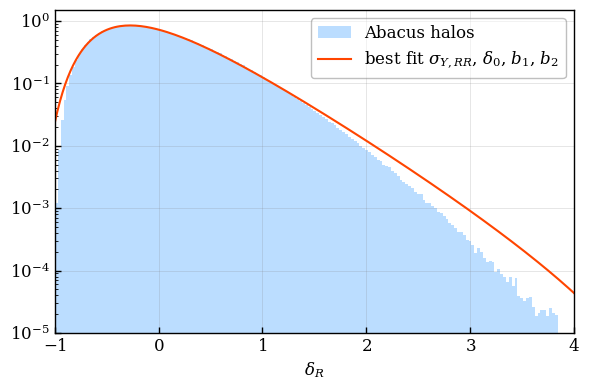

In [48]:
plt.hist(abacus_halos_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus halos')
plt.plot(delta, biased_lognormal_model(delta, sigma_4, delta0_4, b1, b2), color='C1', ls='-', label=r'best fit $\sigma_{Y, RR}$, $\delta_0$, $b_1$, $b_2$')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
plt.yscale('log')
plt.ylim((1e-5, 1.5))
plt.legend()
plt.show()

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0005331407427083301
        x: [ 1.127e+00  6.179e-01  9.406e-01  3.988e-01  6.884e-02]
      nit: 58
      jac: [ 1.592e-06 -1.389e-07 -1.769e-06 -9.647e-08 -6.270e-06]
 hess_inv: [[ 1.002e+00 -2.089e+00 ... -3.757e+00  4.017e-01]
            [-2.089e+00  4.600e+00 ...  8.252e+00 -8.569e-01]
            ...
            [-3.757e+00  8.252e+00 ...  1.542e+01 -1.595e+00]
            [ 4.017e-01 -8.569e-01 ... -1.595e+00  1.735e-01]]
     nfev: 414
     njev: 69


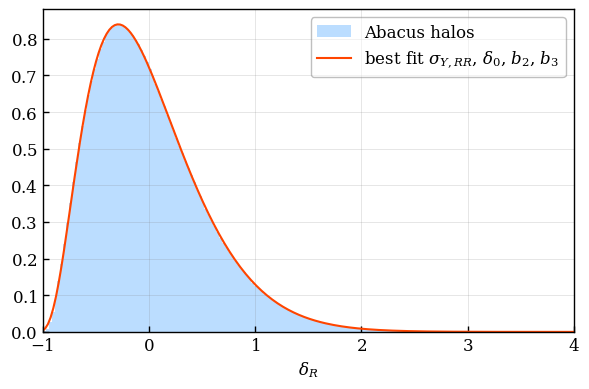

In [28]:
def biased_lognormal_model(delta, sigma, delta0, b1, b2, b3):
    delta2 = delta0**2*(np.exp(sigma**2)-1)
    delta_bias = b1*delta + b2/2.*(delta**2 - delta2) + b3*(delta**3 - (3/delta0**2*delta2 + 1/delta0**3*delta2**(3./2)))
    pdf_model = scipy.stats.lognorm.pdf(delta_bias, sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

delta = np.linspace(-1, 4, 200)

def to_minimize4(params, *args):
    pdf = args
    delta0 = params[0]
    sigma = params[1]
    b1 = params[2]
    b2 = params[3]
    b3 = params[4]
    x = pdf[0]
    y = biased_lognormal_model((pdf[1][1:]+pdf[1][:-1])/2., sigma, delta0, b1, b2, b3)
    return np.sum((x-y)**2)

def compute_bestfit_delta0_sigma_4(delta_R_pdf):
    res = minimize(to_minimize4, x0=np.array([1., model.sigma_RR[0], 1., 0., 0.]), args=delta_R_pdf)
    print(res)
    delta0 = res.x[0]
    sigma = res.x[1]
    b1 = res.x[2]
    b2 = res.x[3]
    b3 = res.x[4]
    return delta0, sigma, b1, b2, b3
    
delta0_4, sigma_4, b1, b2, b3 = compute_bestfit_delta0_sigma_4(pdf_halos)    

plt.rcParams["figure.figsize"] = (6, 4)

plt.hist(abacus_halos_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus halos')
plt.plot(delta, biased_lognormal_model(delta, sigma_4, delta0_4, b1, b2, b3), color='C1', ls='-', label=r'best fit $\sigma_{Y, RR}$, $\delta_0$, $b_2$, $b_3$')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
#plt.yscale('log')
#plt.ylim((1e-5, 1.5))
plt.legend()
plt.show()

## Lognormal model for density splits

In [239]:
nsplits = 3
th_bins = np.array([-1., -0.18346272,  0.09637895, np.inf])

In [18]:
def compute_main_term(delta, sigma, delta0=1., delta0_R=1., bias=1., xi_R=None, shotnoise=None):
    if xi_R is None:
        xi_R = model.xi_R * bias**2
        if shotnoise is not None:
            xi_R = (model.xi_R + shotnoise) * bias**2
    if math.isfinite(delta):
        a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
        b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))
    else:
        if delta > 0:
            a = np.full_like(model.xi_R, 1)
            b = np.full_like(model.xi_R, 1)
        if delta < 0:
            a = np.full_like(model.xi_R, -1)
            b = np.full_like(model.xi_R, -1)
    return a, b

def compute_dsplits(sigma, delta0=1., delta0_R=1., th_bins=th_bins, bias=1., xi_R=None, shotnoise=None):
    dsplits = list()

    for i in range(len(th_bins)-1):
        d1 = max(th_bins[i], -delta0_R)
        d2 = th_bins[i+1]
        a1, b1 = compute_main_term(d1, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R, shotnoise=shotnoise)
        a2, b2 = compute_main_term(d2, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R, shotnoise=shotnoise)
        main_term = (a2 - a1) / (b2 - b1)
        dsplits.append(delta0*(main_term - 1))

    return dsplits

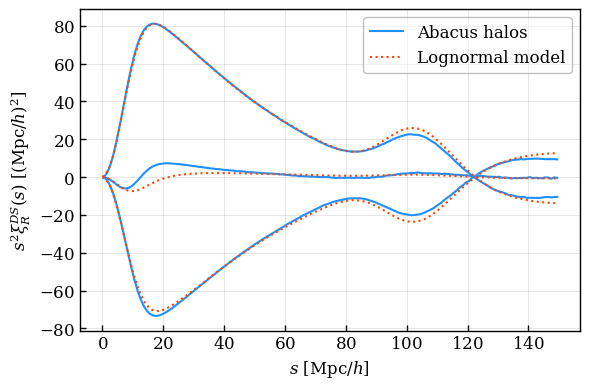

In [233]:
dsplits = compute_dsplits(sigma=sigma, delta0=bias, delta0_R=delta0, bias=bias, xi_R=None, shotnoise=shotnoise)

split_xi_abacus_halos = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_abacus_halos = split_xi_abacus_halos.item()['rh']
split_xi_ells_abacus_halos = [split_xi_abacus_halos[ds].get_corr(ells=ells) for ds in range(nsplits)]
sep, _ = split_xi_abacus_halos[0].get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        plt.plot(sep, sep**2 * split_xi_ells_abacus_halos[ds][0], ls='-', color='C0', alpha=1, label=r'Abacus halos' if ds==0 else '')
        plt.plot(model.sep, model.sep**2 * dsplits[ds], label='Lognormal model' if ds==0 else '', ls=':', color='C1')

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

### Density-split model with bias (numerical integration)

In [578]:
def compute_dsplits_bias(density_bins, sigma, sigmaRR, xi_R, delta0=1., delta0_R=1., b1=1., b2=0.):
    mvn = scipy.stats.multivariate_normal
    cf = list()
    cov = np.array([[np.full_like(xi_R, float(sigma**2)), xi_R],
                    [xi_R, np.full_like(xi_R, float(sigmaRR**2))]])

    for i in range(len(density_bins) - 1):
        res = list()

        d1 = density_bins[i]
        d2 = density_bins[i+1]
        dm1 = get_unbiased_delta(d1, b1, b2, sigma)
        if not math.isfinite(d2):
            dm2 = 3
        else:
            dm2 = get_unbiased_delta(d2, b1, b2, sigma)

        step = np.abs(dm2-dm1)/2000
        #print(step)
        delta = np.dstack(np.mgrid[-10:10:.01, dm1:dm2:step])

        denom = np.array([mvn.cdf(np.array([np.inf, dm2]), cov=cov[:, :, i]) - mvn.cdf(np.array([np.inf, dm1]), cov=cov[:, :, i]) for i in range(len(xi_R))])
        #pdf_delta_m = np.array([mvn.pdf(delta, np.array([0, 0]), cov=cov[:, :, i]) for i in range(len(xi_R))])
        #x = (1 + bias_model(delta[:, :, 0], sigma, b1, b2)[None, ...])*pdf_delta_m
        #extent= dm1, dm2, -10, 10 
        #plt.imshow(x[1], aspect='auto', extent=extent)
        #plt.colorbar()
        #plt.show()
        def func(delta1, delta2, i):
            res = (1 + bias_model(delta1, sigma, b1, b2))*mvn.pdf((delta1, delta2), np.array([0, 0]), cov=cov[:, :, i])
            return res
        def aux(i):
            def lala(a, b):
                return func(a, b, i)
            return lala
        test= np.array([scipy.integrate.dblquad(aux(i), dm1, dm2, -np.inf, np.inf)[0] for i in range(len(xi_R))])
        #inintegral = np.array([np.trapz(x[i], np.mgrid[-10:10:.01], axis=0) for i in range(len(xi_R))])
        #outintegral = np.array([np.trapz(inintegral[i], np.mgrid[dm1:dm2:step]) for i in range(len(xi_R))])
        #res = outintegral/denom - 1
        res = test/denom - 1
                    
        prefactor = - np.sqrt(1/(2*np.pi)) * xi_R/sigmaRR
        num = denom + prefactor * (np.exp(- dm2**2 / (2 * sigmaRR**2)) - np.exp(- dm1**2 / (2 * sigmaRR**2)))
        print(test[1])
        print(num[1])
        
        #print(num[1]/denom[1] - 1)     
        #print(res[1]) 
        cf.append(res)
    return np.array(cf)

In [579]:
test = compute_dsplits_bias(th_bins, sigma=model.sigma, sigmaRR=model.sigma_RR[0], xi_R=model.xi_R.ravel(), delta0=1., delta0_R=1., b1=1., b2=0.)

0.00090826864
0.10033242955589027
0.10033242955591803
0.000139920835
0.3011891269505211
0.3011891269505209
0.001451810525
0.5984784457158023
0.5984784457151764


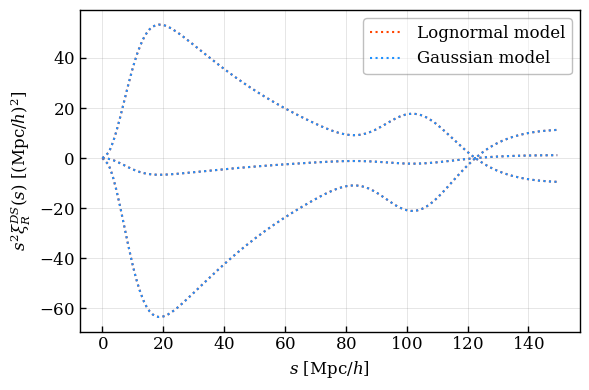

In [580]:
for ds in range(nsplits):
    plt.plot(model.sep, model.sep.ravel()**2 * test[ds], label='Lognormal model' if ds==0 else '', ls=':', color='C1')
    plt.plot(model.sep, model.sep.ravel()**2 * model.ccf_randoms_tracers(th_bins)[ds].ravel(), label='Gaussian model' if ds==0 else '', ls=':', color='C0')

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()